# Tutorial 0: Getting started with MovingPandas

MovingPandas provides a trajectory datatype based on GeoPandas.
The project home is at https://github.com/anitagraser/movingpandas

This tutorial presents some of the trajectory manipulation and visualization functions implemented in MovingPandas.

After following this tutorial, you will have a basic understanding of what MovingPandas is and what it can be used for. You'll be ready to dive into application examples presented in the the follow-up tutorials:
* [Tutorial 1: Ship data analysis](1_ship_data_analysis.ipynb)
* [Tutorial 2: Bird migration analysis](2_bird_migration_analysis.ipynb)

## Introduction

MovingPandas follows the **trajectories = timeseries with geometries** approach of modeling movement data.

A MovingPandas trajectory can be interpreted as either a time series of points or a time series of line segments.
The line-based approach has many advantages for trajectory analysis and visualization. (For more detail, see e.g. Westermeier (2018))

![alt text](./data/trajectory_length.PNG "Trajectory length")
![alt text](./data/trajectory_context.PNG "Trajectory context")
![alt text](./data/trajectory_distance.PNG "Trajectory distance")


### References

* Graser, A. (2019). MovingPandas: Efficient Structures for Movement Data in Python. GI_Forum ‒ Journal of Geographic Information Science 2019, 1-2019, 54-68. doi:10.1553/giscience2019_01_s54. URL: https://www.austriaca.at/rootcollection?arp=0x003aba2b
* Westermeier, E.M. (2018). Contextual Trajectory Modeling and Analysis. Master Thesis, Interfaculty Department of Geoinformatics, University of Salzburg.


## Jupyter notebook setup

In [1]:
%matplotlib inline

In [2]:
import urllib
import os
import pandas as pd
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import sys
sys.path.append("..")
import movingpandas as mpd

import warnings
warnings.simplefilter("ignore")

## Creating a trajectory from scratch

Trajectory objects consist of a trajectory ID and a GeoPandas GeoDataFrame with a DatetimeIndex. The data frame therefore represents the trajectory data as a Pandas time series with associated point locations (and optional further attributes).

Let's create a small toy trajectory to see how this works:

In [3]:
df = pd.DataFrame([
  {'geometry':Point(0,0), 't':datetime(2018,1,1,12,0,0)},
  {'geometry':Point(6,0), 't':datetime(2018,1,1,12,6,0)},
  {'geometry':Point(6,6), 't':datetime(2018,1,1,12,10,0)},
  {'geometry':Point(9,9), 't':datetime(2018,1,1,12,15,0)}
]).set_index('t')
geo_df = GeoDataFrame(df, crs={'init': '31256'})
toy_traj = mpd.Trajectory(1, geo_df)
toy_traj.df

,geometry
t,
2018-01-01 12:00:00,POINT (0 0)
2018-01-01 12:06:00,POINT (6 0)
2018-01-01 12:10:00,POINT (6 6)
2018-01-01 12:15:00,POINT (9 9)


We can access **key information** about our trajectory by looking at the print output:

In [4]:
print(toy_traj)

Trajectory 1 (2018-01-01 12:00:00 to 2018-01-01 12:15:00) | Size: 4 | Length: 16.2m
Bounds: (0.0, 0.0, 9.0, 9.0)
LINESTRING (0 0, 6 0, 6 6, 9 9)


We can also access the trajectories GeoDataFrame:

In [5]:
toy_traj.df

,geometry
t,
2018-01-01 12:00:00,POINT (0 0)
2018-01-01 12:06:00,POINT (6 0)
2018-01-01 12:10:00,POINT (6 6)
2018-01-01 12:15:00,POINT (9 9)


## Visualizing trajectories

To **visualize the trajectory**, we can turn it into a linestring.

(The notebook environment automatically plots Shapely geometry objects like the LineString returned by to_linestring().)

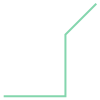

In [6]:
toy_traj.to_linestring()

We can **compute the speed** of movement along the trajectory (between consecutive points). The values are in meters per second:

In [7]:
toy_traj.add_speed(overwrite=True)
toy_traj.df

,geometry,speed
t,,
2018-01-01 12:00:00,POINT (0 0),0.016667
2018-01-01 12:06:00,POINT (6 0),0.016667
2018-01-01 12:10:00,POINT (6 6),0.025000
2018-01-01 12:15:00,POINT (9 9),0.014142


We can also visualize the speed values:

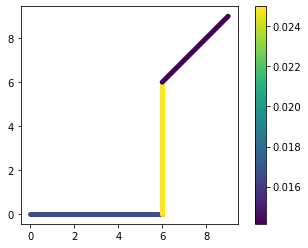

In [8]:
toy_traj.plot(column="speed", linewidth=5, capstyle='round', legend=True)

In contrast to the earlier example where we visualized the whole trajectory as one linestring, the trajectory plot() function draws each line segment individually and thus each can have a different color.

## Analyzing trajectories

MovingPandas provides many functions for trajectory analysis. 

To see all available functions of the MovingPandas.Trajectory class use:

In [9]:
dir(mpd.Trajectory)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_distance',
 '_compute_heading',
 '_compute_speed',
 '_connect_prev_pt_and_geometry',
 '_to_line_df',
 'add_direction',
 'add_prev_pt',
 'add_speed',
 'apply_offset_minutes',
 'apply_offset_seconds',
 'clip',
 'copy',
 'generalize',
 'generalize_douglas_peucker',
 'generalize_min_time_delta',
 'get_bbox',
 'get_df_with_speed',
 'get_direction',
 'get_duration',
 'get_end_location',
 'get_end_time',
 'get_length',
 'get_linestring_between',
 'get_position_at',
 'get_row_at',
 'get_segment_between',
 'get_start_location',
 'get_start_time',
 'has_parent',
 'interpolate_position_at',
 'intersection',
 'intersects',


Functions that start with an underscore (e.g. ```__str__```) should not be called directly. All other functions are free to use.

### Extracting a moving object's position was at a certain time

For example, let's have a look at the get_position_at() function:

In [10]:
help(mpd.Trajectory.get_position_at)

Help on function get_position_at in module movingpandas.trajectory:

get_position_at(self, t, method='interpolated')
    Return shapely Point at given datetime using the provided method.



When we call this method, the resulting point is directly rendered:

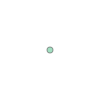

In [11]:
toy_traj.get_position_at(datetime(2018,1,1,12,6,0), method="nearest")    

To see its coordinates, we can look at the print output:

In [12]:
print(toy_traj.get_position_at(datetime(2018,1,1,12,6,0), method="nearest"))

POINT (6 0)


The method parameter describes what the function should do if there is no entry in the trajectory GeoDataFrame for the specified timestamp. 

For example, there is no entry at 2018-01-01 12:07:00

In [13]:
toy_traj.df

,geometry,speed
t,,
2018-01-01 12:00:00,POINT (0 0),0.016667
2018-01-01 12:06:00,POINT (6 0),0.016667
2018-01-01 12:10:00,POINT (6 6),0.025000
2018-01-01 12:15:00,POINT (9 9),0.014142


In [14]:
print(toy_traj.get_position_at(datetime(2018,1,1,12,7,0), method="nearest"))
print(toy_traj.get_position_at(datetime(2018,1,1,12,7,0), method="interpolated"))
print(toy_traj.get_position_at(datetime(2018,1,1,12,7,0), method="ffill")) # from the previous row
print(toy_traj.get_position_at(datetime(2018,1,1,12,7,0), method="bfill")) # from the following row

POINT (6 0)
POINT (6 1.5)
POINT (6 0)
POINT (6 6)


### Extracting trajectory segments based on time or geometry (i.e. clipping)

First, let's extract the trajectory segment for a certain time period:

In [15]:
segment = toy_traj.get_segment_between(datetime(2018,1,1,12,6,0),datetime(2018,1,1,12,12,0))
print(segment)

Trajectory 1 (2018-01-01 12:06:00 to 2018-01-01 12:10:00) | Size: 2 | Length: 6.0m
Bounds: (6.0, 0.0, 6.0, 6.0)
LINESTRING (6 0, 6 6)


Now, let's extract the trajectory segment that intersects with a given polygon:

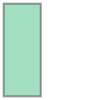

In [16]:
xmin, xmax, ymin, ymax = 2, 8, -10, 5
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
polygon

In [17]:
intersections = toy_traj.clip(polygon)
print(intersections[0])

Trajectory 1_0 (2018-01-01 12:02:00 to 2018-01-01 12:09:20) | Size: 3 | Length: 9.0m
Bounds: (2.0, 0.0, 6.0, 5.0)
LINESTRING (2 0, 6 0, 6 5)


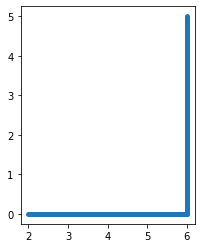

In [18]:
intersections[0].plot(linewidth=5, capstyle='round')

## Beyond toy trajectories: loading trajectory data from GeoPackage

The MovingPandas repository contains a demo GeoPackage file that can be loaded as follows:

In [19]:
url = 'https://github.com/anitagraser/movingpandas/raw/master/tutorials/data/demodata_geolife.gpkg'
filename = url.split('/')[-1] 

response = urllib.request.urlopen(url)
content = response.read()
with open(filename, 'wb' ) as f:
    f.write( content )

In [20]:
assert(os.path.exists(filename))

Now, we can use GeoPandas' read_file() function to read the GeoPackage and construct the Trajectories:

In [21]:
%%time
df = read_file(filename)
df['t'] = pd.to_datetime(df['t'])
df = df.set_index('t').tz_localize(None)
print("Finished reading {} rows".format(len(df)))

Finished reading 5908 rows
Wall time: 137 ms


After reading the trajectory point data from file, we want to construct the trajectories.

There are two options:

1. Manually calling the Trajectory constructor
2. Using TrajectoryManager

### Option 1: Creating trajectories manually

Pandas makes it straightforward to trajectory points by trajectory id. After the grouping step, we can call the Trajectory constructor: 

In [22]:
%%time
trajectories = []
for key, values in df.groupby(['trajectory_id']):
    trajectory = mpd.Trajectory(key, values)
    print(trajectory)
    trajectories.append(trajectory)

print("Finished creating {} trajectories".format(len(trajectories)))

Trajectory 1 (2008-12-11 04:42:14 to 2008-12-11 05:15:46) | Size: 466 | Length: 6210.1m
Bounds: (116.385602, 39.862378, 116.393553, 39.898723)
LINESTRING (116.391305 39.898573, 116.391317 39.898617, 116.390928 39.898613, 116.390833 39.898635, 
Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 38728.7m
Bounds: (116.319212, 39.971703, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 
Trajectory 3 (2009-02-04 04:32:53 to 2009-02-04 11:20:12) | Size: 1810 | Length: 12739.2m
Bounds: (116.332706, 39.897023, 116.387307, 39.927949)
LINESTRING (116.385689 39.899773, 116.385654 39.899651, 116.385548 39.899699, 116.385527 39.899632, 
Trajectory 4 (2009-03-10 10:36:45 to 2009-03-10 12:01:07) | Size: 1864 | Length: 14357.6m
Bounds: (116.327347, 39.896671, 116.389611, 39.927947)
LINESTRING (116.388053 39.903418, 116.388042 39.9035, 116.388035 39.903467, 116.388061 39.903541, 11
Trajectory 5 (2009-

### Option 2: Creating trajectories with TrajectoryManager

TrajectoryManager is a convenience class that takes care of creating trajectories from a GeoDataFrame:

In [23]:
trajectory_manager = mpd.TrajectoryManager(df, 'trajectory_id')
print(trajectory_manager)

TrajectoryManager with 5 trajectories


Let's look at one of those trajectories:

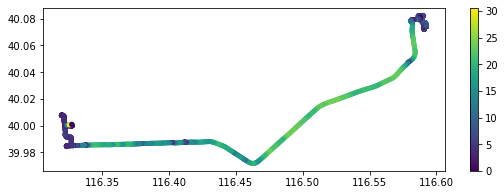

In [24]:
trajectories = trajectory_manager.trajectories
trajectories[1].plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True)

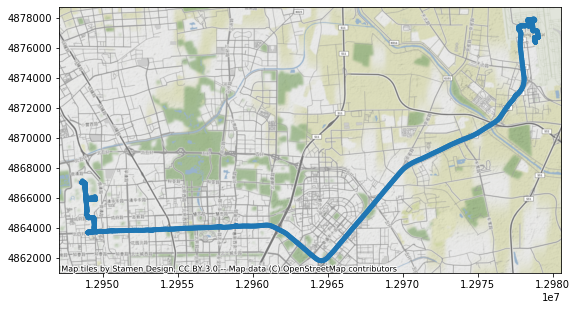

In [25]:
trajectories[1].plot(with_basemap=True, linewidth=5.0, capstyle='round', figsize=(9,9))

### Finding intersections with a Shapely polygon

In [26]:
xmin, xmax, ymin, ymax = 116.3685035,116.3702945,39.904675,39.907728
polygon = Polygon([(xmin,ymin), (xmin,ymax), (xmax,ymax), (xmax,ymin), (xmin,ymin)])

intersections = []
for traj in trajectories:
    for intersection in traj.clip(polygon):
        intersections.append(intersection)
print("Found {} intersections".format(len(intersections)))

Found 3 intersections


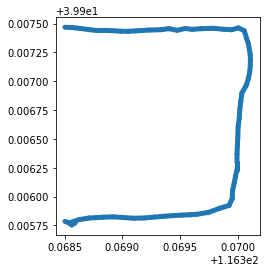

In [27]:
intersections[2].plot(linewidth=5.0, capstyle='round')

## Splitting trajectories

Gaps are quite common in trajectories. For example, GPS tracks may contain gaps if moving objects enter tunnels where GPS reception is lost. In other use cases, moving objects may leave the observation area for longer time before returning and continuing their recorded track.

Depending on the use case, we therefore might want to split trajectories at observation gaps that exceed a certain minimum duration:

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 38728.7m
Bounds: (116.319212, 39.971703, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 


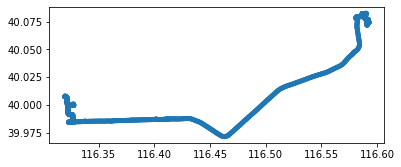

In [28]:
my_traj = trajectories[1]
print(my_traj)
my_traj.plot(linewidth=5.0, capstyle='round')

In [29]:
split = my_traj.split_by_observation_gap(timedelta(minutes=5))
for traj in split:
    print(traj)

Trajectory 2_0 (2009-06-29 07:02:25 to 2009-06-29 07:17:05) | Size: 152 | Length: 2554.1m
Bounds: (116.586342, 40.07196, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 
Trajectory 2_1 (2009-06-29 07:29:35 to 2009-06-29 08:20:15) | Size: 619 | Length: 33733.3m
Bounds: (116.319212, 39.971703, 116.587085, 40.079854)
LINESTRING (116.587031 40.07951, 116.587041 40.079514, 116.587032 40.079524, 116.586998 40.079528, 1
Trajectory 2_2 (2009-06-29 10:57:17 to 2009-06-29 11:13:12) | Size: 126 | Length: 2326.4m
Bounds: (116.319598, 39.999772, 116.327485, 40.007696)
LINESTRING (116.319697 40.007513, 116.319706 40.007586, 116.319636 40.007687, 116.319598 40.007696, 


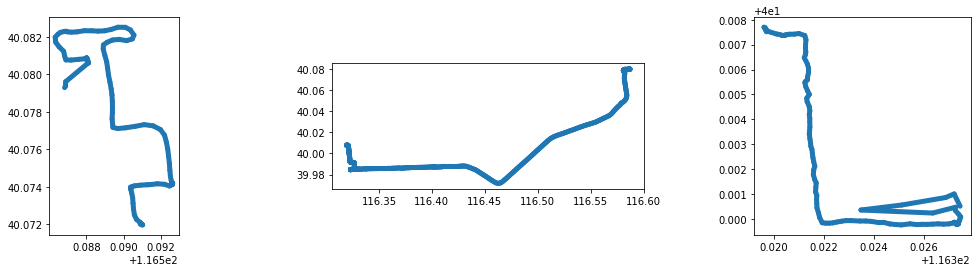

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(19,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round')

## Generalizing trajectories

To reduce the size of trajectory objects, we can generalize them, for example, using the Douglas-Peucker algorithm:

In [31]:
original_traj = trajectories[1]
print(original_traj)

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 38728.7m
Bounds: (116.319212, 39.971703, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 


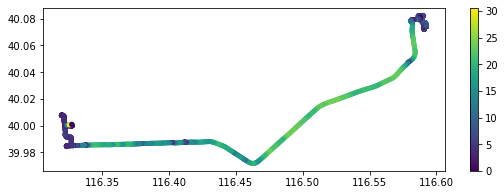

In [32]:
original_traj.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True)

Try different tolerance settings and observe the results in line geometry and therefore also length:

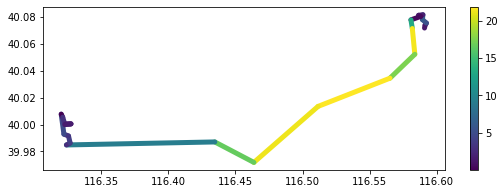

In [33]:
generalized_traj = original_traj.generalize(mode='douglas-peucker', tolerance=0.001)
generalized_traj.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True)

In [34]:
print('Original length: %s'%(original_traj.get_length()))
print('Generalized length: %s'%(generalized_traj.get_length()))

Original length: 38728.7215399247
Generalized length: 36295.61630501229


An alternative generalization method is to down-sample the trajectory to ensure a certain time delta between records:

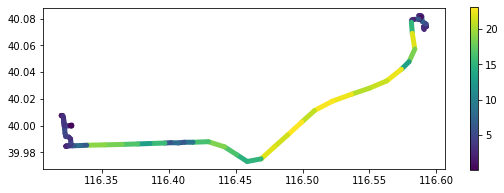

In [35]:
time_generalized = original_traj.generalize(mode='min-time-delta', tolerance=timedelta(minutes=1))
time_generalized.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True)

In [36]:
time_generalized.df.head(10)

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.590957 40.071961)
2009-06-29 07:03:25,1569,1103,2,0,POINT (116.590686 40.072249)
2009-06-29 07:04:25,1582,1116,2,0,POINT (116.590368 40.073956)
2009-06-29 07:05:25,1595,1129,2,0,POINT (116.592604 40.074115)
2009-06-29 07:06:25,1610,1144,2,0,POINT (116.592585 40.074198)
2009-06-29 07:07:25,1623,1157,2,0,POINT (116.592349 40.076016)
2009-06-29 07:08:25,1635,1169,2,0,POINT (116.589395 40.077941)
2009-06-29 07:09:25,1647,1181,2,0,POINT (116.589112 40.08171)
2009-06-29 07:10:25,1659,1193,2,0,POINT (116.588289 40.082325)


In [37]:
original_traj.df.head(10)

,id,sequence,trajectory_id,tracker,geometry
t,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.590957 40.071961)
2009-06-29 07:02:30,1557,1091,2,0,POINT (116.590905 40.072007)
2009-06-29 07:02:35,1558,1092,2,0,POINT (116.590879 40.072027)
2009-06-29 07:02:40,1559,1093,2,0,POINT (116.590915 40.072004)
2009-06-29 07:02:45,1560,1094,2,0,POINT (116.590961 40.071983)
2009-06-29 07:02:50,1561,1095,2,0,POINT (116.591012 40.07196)
2009-06-29 07:02:55,1562,1096,2,0,POINT (116.590986 40.071984)
2009-06-29 07:03:00,1563,1097,2,0,POINT (116.590975 40.071993)
2009-06-29 07:03:05,1564,1098,2,0,POINT (116.590973 40.071995)


## Continue exploring MovingPandas

* [Tutorial 1: Ship data analysis](1_ship_data_analysis.ipynb)
* [Tutorial 2: Bird migration analysis](2_bird_migration_analysis.ipynb)